# Fitting Neural Net
We fit a Neural Net to the Sepsis data in this note

In [1]:
import pandas as pd
import numpy as np
exportdir='/Users/faaiz/exportdir'

In [2]:
import logging
logging.basicConfig(filename='neural-net.log', level=logging.INFO)

In [6]:
nra = 5

## Import Data

In [3]:
MIMICraw = pd.read_csv(exportdir + '/MIMICraw-logistic_reg.csv')
MIMICraw.head()

,gender,mechvent,re_admission,age,Weight_kg,GCS,HR,SysBP,MeanBP,DiaBP,...,Creatinine,SGOT,SGPT,Total_bili,INR,output_total,output_4hourly,last_input,total_input_before,last_vaso_dose
0,-0.5,-0.5,-0.5,0.123860,-0.870259,0.477695,0.579580,-0.387404,-0.589746,-0.423179,...,-0.502852,0.013289,-0.722894,-1.088681,1.015870,-0.127732,0.564887,-1.281663,-1.798569,-0.5
1,-0.5,-0.5,-0.5,0.123860,-0.108596,0.477695,0.745287,1.203395,1.488158,1.434798,...,-0.502852,0.276745,0.396998,0.067177,1.015870,0.046116,0.564887,-1.281663,-1.798569,-0.5
2,-0.5,-0.5,-0.5,0.123860,4.297972,0.477695,0.789346,-0.199873,0.280315,0.743097,...,-0.502852,-0.230115,-0.442009,-0.147049,-0.741218,0.158831,0.530796,-1.281663,-1.798569,-0.5
3,0.5,-0.5,-0.5,1.041991,-1.050288,0.477695,-0.842034,1.476385,-0.467412,-1.759465,...,1.651291,0.013289,-0.442009,-0.423234,0.089840,-0.335917,0.395338,-1.281663,-1.798569,-0.5
4,0.5,-0.5,-0.5,1.041991,-1.050288,0.477695,-1.464791,0.055757,-1.281419,-1.830870,...,1.651291,0.013289,-0.442009,-0.423234,0.089840,-0.185300,0.347398,0.247181,0.585980,-0.5


In [4]:
MIMICtable = pd.read_csv(exportdir + '/MIMICtable.csv')
MIMICtable.head()

,bloc,icustay_id,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,mechvent,Shock_Index,PaO2_FiO2,median_dose_vaso,max_dose_vaso,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance
0,1.0,1006.0,4.330306e+09,0.0,25154.170995,3.0,0.0,1.0,1.0,1.0,...,0.0,0.908732,257.500000,0.0,0.0,0.000000,0.000000,8166.0,4083.0,-8166.000000
1,3.0,1006.0,4.330335e+09,0.0,25154.170995,3.0,0.0,1.0,1.0,1.0,...,0.0,0.728457,294.285714,0.0,0.0,0.000000,0.000000,12249.0,4083.0,-12249.000000
2,6.0,1006.0,4.330378e+09,0.0,25154.170995,3.0,0.0,1.0,1.0,1.0,...,0.0,0.912791,104.727273,0.0,0.0,275.000000,275.000000,15932.0,3683.0,-15657.000000
3,1.0,1204.0,4.794583e+09,1.0,29424.868472,5.0,0.0,0.0,0.0,1.0,...,0.0,0.504678,116.666667,0.0,0.0,5036.666667,36.666667,5025.0,2445.0,11.666667
4,2.0,1204.0,4.794597e+09,1.0,29424.868472,5.0,0.0,0.0,0.0,1.0,...,0.0,0.528184,116.666667,0.0,0.0,5708.720883,672.054217,7140.0,2115.0,-1431.279117


## Create Actions

In [7]:
from sklearn.cluster import KMeans
from scipy.stats import rankdata

logging.info('Creating action bins')
nact = nra**2
input_4hourly_nonzero = MIMICtable.loc[MIMICtable['input_4hourly']>0, 'input_4hourly']
iol_ranked = rankdata(input_4hourly_nonzero)/len(input_4hourly_nonzero) # excludes zero fluid (will be action 1)
iof = np.floor((iol_ranked + 0.2499999999)*4) # converts iv volume in 4 actions
io = np.ones(len(MIMICtable)) # array of ones, by default
io[MIMICtable['input_4hourly']>0] = iof + 1 # where more than zero fluid given: save actual action
vc = MIMICtable['max_dose_vaso'].copy()
vc_nonzero = MIMICtable.loc[MIMICtable['max_dose_vaso']!=0, 'max_dose_vaso']
vc_ranked = rankdata(vc_nonzero)/len(vc_nonzero)
vcf = np.floor((vc_ranked + 0.2499999999)*4) # converts to 4 bins
vcf[vcf==0] = 1
vc[vc!=0] = vcf + 1
vc[vc==0] = 1
# median dose of drug in all bins
ma1 = [MIMICtable.loc[io==1, 'input_4hourly'].median(), MIMICtable.loc[io==2, 'input_4hourly'].median(), MIMICtable.loc[io==3, 'input_4hourly'].median(), MIMICtable.loc[io==4, 'input_4hourly'].median(), MIMICtable.loc[io==5, 'input_4hourly'].median()]
ma2 = [MIMICtable.loc[vc==1, 'max_dose_vaso'].median(), MIMICtable.loc[vc==2, 'max_dose_vaso'].median(), MIMICtable.loc[vc==3, 'max_dose_vaso'].median(), MIMICtable.loc[vc==4, 'max_dose_vaso'].median(), MIMICtable.loc[vc==5, 'max_dose_vaso'].median()]
med = pd.DataFrame(data={'IV':io, 'VC': vc})
med = med.astype({'IV': 'int32', 'VC': 'int32'})
uniqueValues = med.drop_duplicates().reset_index(drop=True)
uniqueValueDoses = pd.DataFrame()
for index, row in uniqueValues.iterrows():
    uniqueValueDoses.at[index, 'IV'], uniqueValueDoses.at[index, 'VC'] = ma1[row['IV']-1], ma2[row['VC']-1]

actionbloc = pd.DataFrame()
for index, row in med.iterrows():
    actionbloc.at[index, 'action_bloc'] = uniqueValues.loc[(uniqueValues['IV'] == row['IV']) & (uniqueValues['VC'] == row['VC'])].index.values[0]+1
actionbloc = actionbloc.astype({'action_bloc':'int32'})

logging.info('Action bins created')

## Create Training and Test data

In [9]:
icuuniqueids = MIMICtable['icustay_id'].unique()
grp = np.floor(5*np.random.rand(len(icuuniqueids))+1)
crossval = 1
trainidx = icuuniqueids[grp != crossval]
testidx = icuuniqueids[grp == crossval]
X = MIMICraw.loc[MIMICtable['icustay_id'].isin(trainidx)]
Xtestmimic = MIMICraw[MIMICtable['icustay_id'].isin(testidx)]
blocs = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'bloc']
bloctestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'bloc']
ptid = MIMICtable.loc[MIMICtable['icustay_id'].isin(trainidx), 'icustay_id']
ptidtestmimic = MIMICtable.loc[MIMICtable['icustay_id'].isin(testidx), 'icustay_id']
Y = actionbloc.loc[MIMICtable['icustay_id'].isin(trainidx), 'action_bloc']
Ytest = actionbloc.loc[MIMICtable['icustay_id'].isin(testidx), 'action_bloc']


## Define the Neural Network Architecture

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(47, 50)
        self.lin2 = nn.Linear(50, 50)
        self.lin3 = nn.Linear(50, nact)

    def forward(self, xb):
        xb = F.relu(self.lin1(xb))
        xb = F.relu(self.lin2(xb))
        xb = F.softmax(self.lin3(xb), dim=1)
        return xb
    

loss_func = F.cross_entropy        

In [36]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=0.001)

In [15]:
X, Y, Xtestmimic, Ytest = map(torch.tensor, (X.values, Y.values, Xtestmimic.values, Ytest.values))

In [44]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_ds = TensorDataset(X, Y)
train_dl = DataLoader(train_ds, batch_size=32)

test_ds = TensorDataset(Xtestmimic, Ytest)
test_dl = DataLoader(test_ds, batch_size=32*2)


## Training

In [94]:
model, opt = get_model()
test_loss = []
logging.info('Starting training')

for epoch in range(10):
    logging.info('Epoch: ' + str(epoch))
    model.train()
    for xb, yb in train_dl:
        pred = model(xb.float())
        loss = loss_func(pred, yb.long())

        loss.backward()
        opt.step()
        opt.zero_grad()
    
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb.float()), yb.long()) for xb, yb in test_dl)
        test_loss.append(valid_loss)

logging.info('Training finished')
print(loss_func(model(xb.float()), yb.long()))

tensor(2.8813, grad_fn=<NllLossBackward>)


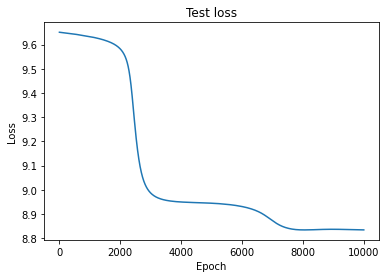

In [95]:
import matplotlib.pyplot as plt

plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

In [100]:
mismatches = 0
for xb, yb in test_dl:
    pred = model(xb.float())
    _, predicted = torch.max(pred, 1)
    mismatches += (predicted != yb).sum()

score = 1 - mismatches.float()/len(test_dl.dataset)
print(score.item())

0.3660130500793457
